The Log-Likelihood function of a binned poisson and gaussian is:

$l(n_i, y_i | \mu_i, s_i, \sigma_i) = \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i) -\frac{N}{2} \log{2 \pi \sigma_i^2} - \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$

Let's split them up into several terms for convenience in computing:

Term 1: $n_i \log{(\mu_i + s_i)}$

Term 2: $ - N(\mu_i + s_i)$

Term 3: $-\frac{N}{2} \log{2 \pi \sigma_i^2}$

Term 4: $- \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$
    

In [23]:
import autograd.numpy as np
from autograd.numpy import linalg
import matplotlib.pyplot as plt


def neg_log_like_PGP_binned(mu, s, ni, y, sigma):
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N or len(sigma)!=N):
        raise ValueError('Input arrays are not all the same length')
    result = 0.
    for i in range(N):
        result += ni[i] * np.log(mu[i] + s[i])
        result += -N*(mu[i] + s[i])
        result += -(N/2) * np.log(2. * np.pi * np.power(sigma[i],2))
        result += -(1./2) *  (np.power((1./sigma[i]),2) * np.power((y[i]-mu[i]),2))
        #result[i] = t1+t2+t3+t4
    return -result
    
    '''if np.isnan(result[i]):
            if np.isnan(t1):
                print("At index " + str(i)+ "\nt1 broke with values\nn: "+ str(ni[i]) + "\nmu: " + str(mu[i])+ "\ns: "+ str(s[i]))
            if np.isnan(t2):
                print("At index " + str(i)+ "\nt2 broke with values\nmu: " + str(mu[i])+ "\ns: "+ str(s[i]))
            if np.isnan(t3):
                print("At index " + str(i)+ "\nt3 broke with values\nsigma: "+ str(sigma[i]))
            if np.isnan(t4):
                print("At index " + str(i)+ "\nt4 broke with values\nsigma: "+ str(sigma[i]) + "\nmu: " + str(mu[i])+ "\ns: "+ str(s[i]))'''
    

Similarly, for the multivariate Gaussian case, we can write the log-likelihood function as:

$l(n_i, x_i | \mu_i, s_i, \Sigma) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i)$



In [24]:
def neg_log_like_PGP_MV(mu, s, ni, x, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(x)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    result = -(N/2.)*np.log(2*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (x-mu)[np.newaxis]
    result -= (1./2) * np.dot(np.dot(resid,invcov),resid.T)
    for i in range(N):
        result += ni[i] * np.log(mu[i] + s[i])
        result -= N*(mu[i] + s[i])
    return -result[0][0]
        
    

In [25]:
from autograd import grad

nln_bin_gminerad = grad(neg_log_like_PGP_binned)
nln_MV_grad = grad(neg_log_like_PGP_MV)

In [26]:
def f1(x):
    return (1000./(np.exp(x-2)))

def f2(x):
    return 1000./x

def f3(x):
    return 1000.*np.exp(-3.*(x-0.7))

def f4(x):
    return (1000./np.log(x+1))

def f5(x):
    return 1000./(np.power(x+.3,2))



In [27]:
def makekernel(x, k, params, sigma = 0.):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    if len(sigma)>1:
        for i in range(N):
            cov[i][i] = sigma[i]**2
    return cov

#kernel with constant lengthscale but variable height
def kernel1(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    result = A * np.exp(-(((x1-x2)**2)/(((b*x1 + c)**2)+((b*x2 + c)**2)))+((d-(x1+x2))/(2.*a)))
    return result

def simulate(ytrue, cov):
    y0 = np.abs(np.random.multivariate_normal(ytrue, cov))
    mu = np.random.poisson(y0)
    return mu


<IPython.core.display.Javascript object>


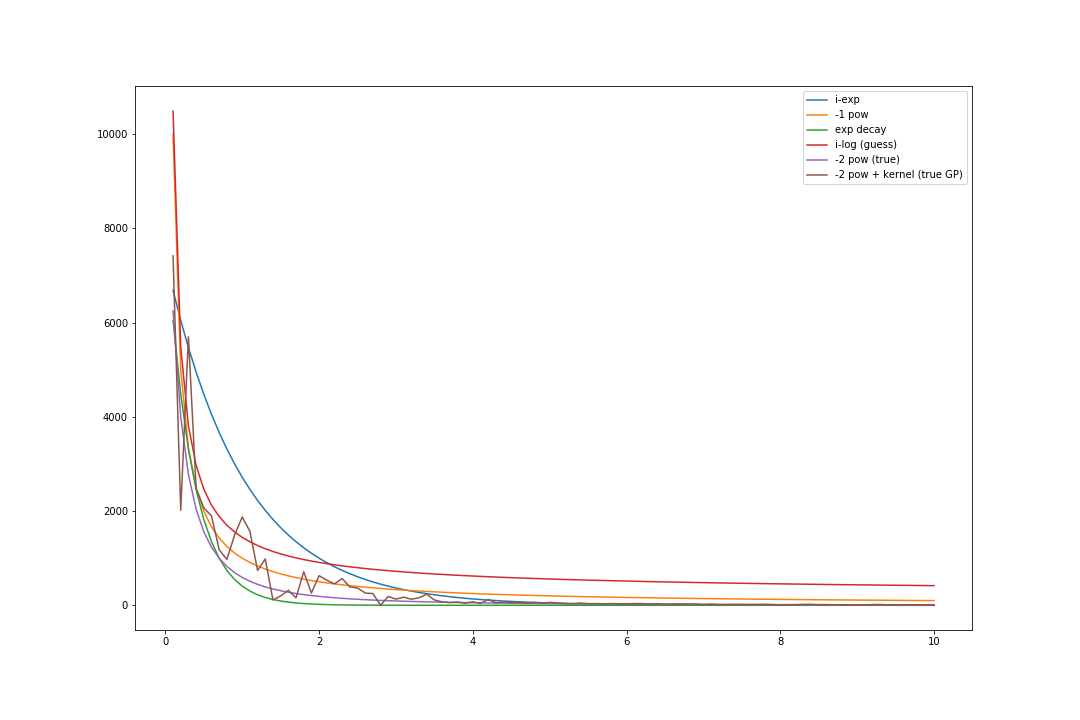

<IPython.core.display.Javascript object>


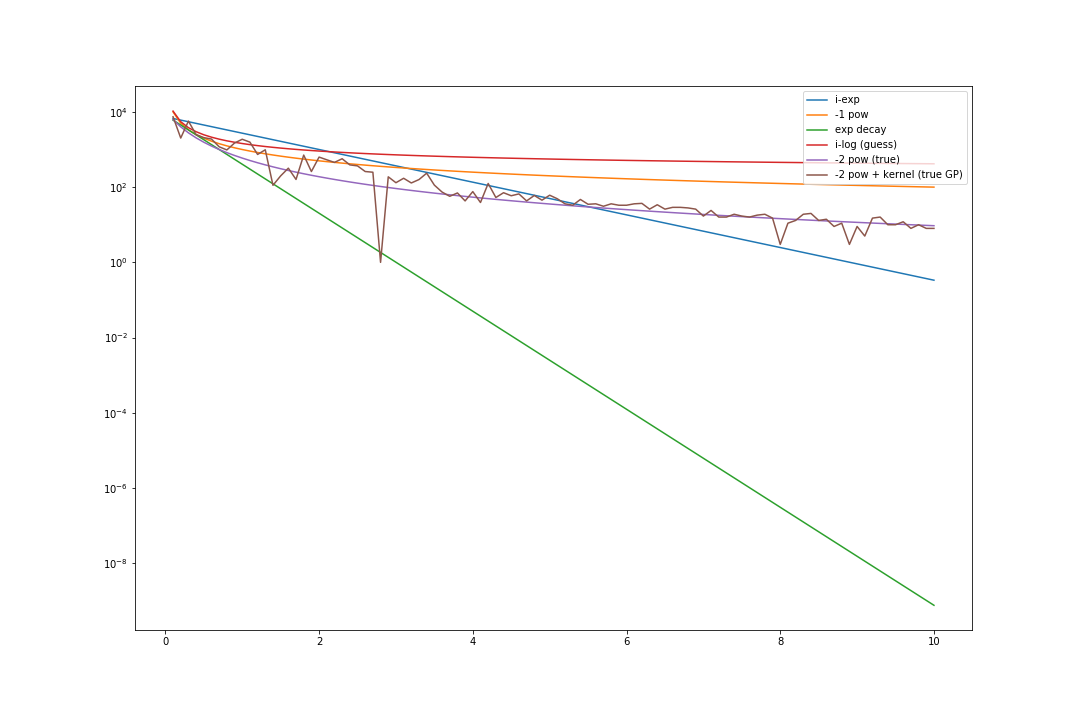

In [28]:
N= 100
x = np.linspace(.1,10,N)
scale = 1
kparams = [100., .5, 1., 0., 10.]

y1 =  scale * f1(x)
y2 = scale * f2(x)
y3 = scale * f3(x)
yguess = scale * f4(x)
ytrue = scale * f5(x)

cov = makekernel(x, kernel1, kparams, sigma = np.sqrt(ytrue))
ytrueGP = simulate(ytrue, cov)


plt.figure(figsize=(15,10))
plt.plot(x,y1, label = "i-exp")
plt.plot(x,y2, label = "-1 pow")
plt.plot(x,y3, label = "exp decay")
plt.plot(x,yguess, label = "i-log (guess)")
plt.plot(x,ytrue, label = "-2 pow (true)")
plt.plot(x,ytrueGP, label = "-2 pow + kernel (true GP)")
plt.legend(loc='upper right')

plt.figure(figsize=(15,10))
plt.semilogy(x,y1, label = "i-exp")
plt.semilogy(x,y2, label = "-1 pow")
plt.semilogy(x,y3, label = "exp decay")
plt.semilogy(x,yguess, label = "i-log (guess)")
plt.semilogy(x,ytrue, label = "-2 pow (true)")
plt.semilogy(x,ytrueGP, label = "-2 pow + kernel (true GP)")
plt.legend(loc='upper right')

plt.show()

In [29]:
from autograd.numpy.random import poisson
n = poisson(ytrue)
sigma = np.sqrt(n+1)

In [30]:
from scipy.optimize import minimize
boundarray = [(0,None) for i in n]
signal0 = np.zeros(len(n))
soln = minimize(neg_log_like_PGP_binned, yguess-n,  bounds = boundarray, args = (signal0, n, yguess, sigma), jac=nln_bin_gminerad)
print soln

      fun: 5042387.916959407
 hess_inv: <100x100 LbfgsInvHessProduct with dtype=float64>
      jac: array([97.51684246, 96.19569889, 95.99307014, 96.29776084, 97.0242853 ,
       97.37468809, 97.67300608, 97.91020159, 97.98297662, 98.05117163,
       98.06748443, 98.13124677, 98.17723005, 98.20027772, 98.22519751,
       98.2341951 , 98.22987848, 98.2056642 , 98.19216451, 98.15236379,
       98.12711075, 98.10905632, 98.08842593, 98.10316268, 98.01002424,
       98.02782112, 97.99629822, 97.95626748, 97.85897388, 97.83981032,
       97.58629683, 97.76592557, 97.75275816, 97.48282224, 97.44459379,
       97.29761005, 97.42080605, 97.16604137, 97.37698265, 97.18931864,
       97.4108192 , 95.96378611, 97.20950126, 96.40494844, 96.40378617,
       96.20040076, 96.40150144, 95.77126726, 96.57114476, 96.56994039,
       96.39708035, 96.11916892, 95.43589551, 95.30803243, 95.3073638 ,
       93.79759219, 94.49352091, 95.30539817, 96.50560286, 94.68319068,
       95.30348939, 94.85710542, 93.

In [31]:
solnGP = minimize(neg_log_like_PGP_MV, yguess-ytrueGP,  bounds = boundarray, args = (signal0 , ytrueGP, yguess, cov), jac=nln_MV_grad)
print solnGP

      fun: nan
 hess_inv: <100x100 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 97.58301777,  99.41232795,         -inf,  94.89554633,
        94.76082987,  91.73667694,  98.323575  ,  98.6638137 ,
        79.05783914,         -inf,         -inf,  98.6078481 ,
        95.48815847,  99.89024864,  99.77543014,  99.55997731,
        99.80612421,  97.27038536,  99.61081222,  97.76485076,
        98.48003202,  98.87790122,  97.89562924,  99.08211095,
        99.14382803,  99.48843073,  99.50430508,  99.95671888,
        99.63817057,  99.75104434,  99.66208986,  99.74652517,
        99.68401446,  99.48931734,  99.77080667,  99.82860287,
        99.84744232,  99.83316008,  99.85506623,  99.83570364,
        99.85119552,  99.85128484,  99.8604243 ,  99.8960972 ,
        99.90116748,  99.95516649,  99.89572818, 100.04257225,
        99.98886322, 100.27708514, 100.25429449, 100.11858757,
       100.19009798, 101.46407132, 101.64284258, 110.65959519,
        96.20842163,  97.2073367

<IPython.core.display.Javascript object>


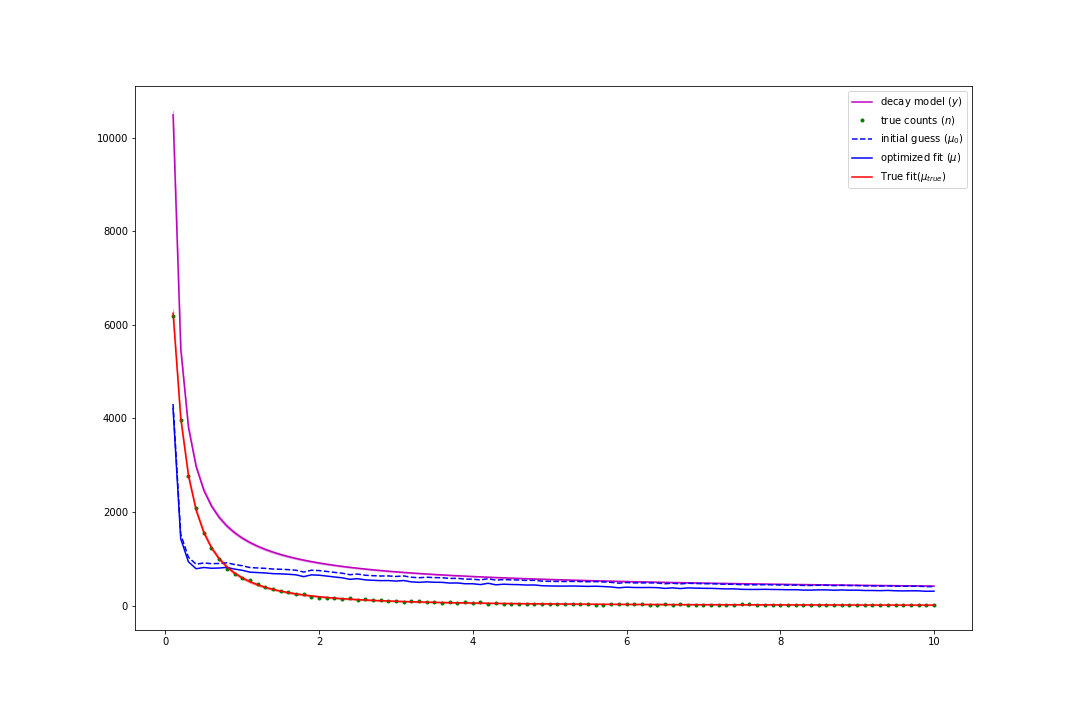

<IPython.core.display.Javascript object>


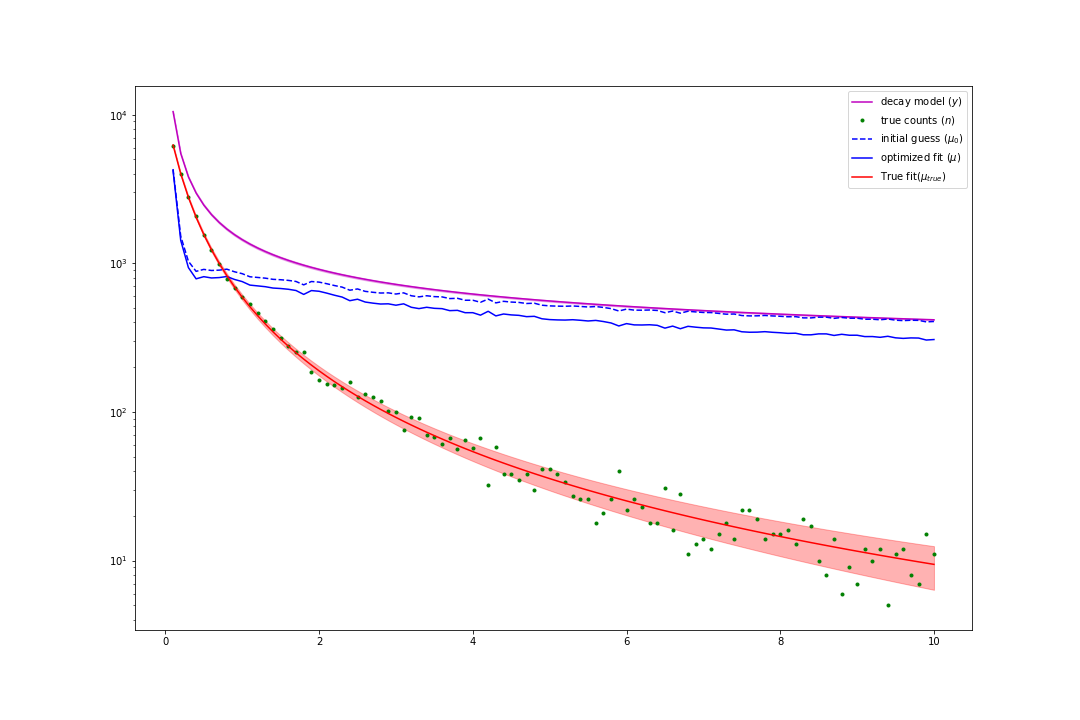

In [32]:
plt.figure(figsize=(15,10))

plt.plot(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+np.sqrt(np.diag(cov)), yguess-np.sqrt(np.diag(cov)), color = 'm', alpha=0.3, edgecolor="none")
plt.plot(x, n,'g.', label = "true counts ($n$)")
plt.plot(x, yguess-n,'b--', label = "initial guess ($\mu_0$)")
plt.plot(x, soln.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.legend(loc="upper right")
plt.figure(figsize=(15,10))

plt.semilogy(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+np.sqrt(np.diag(cov)), yguess-np.sqrt(np.diag(cov)), color = 'm', alpha=0.3, edgecolor="none")
plt.semilogy(x, n,'g.', label = "true counts ($n$)")
plt.semilogy(x, yguess-n,'b--', label = "initial guess ($\mu_0$)")
plt.semilogy(x, soln.x,'b-', label = "optimized fit ($\mu$)")
plt.semilogy(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")

plt.legend(loc="upper right")
plt.show()

<IPython.core.display.Javascript object>


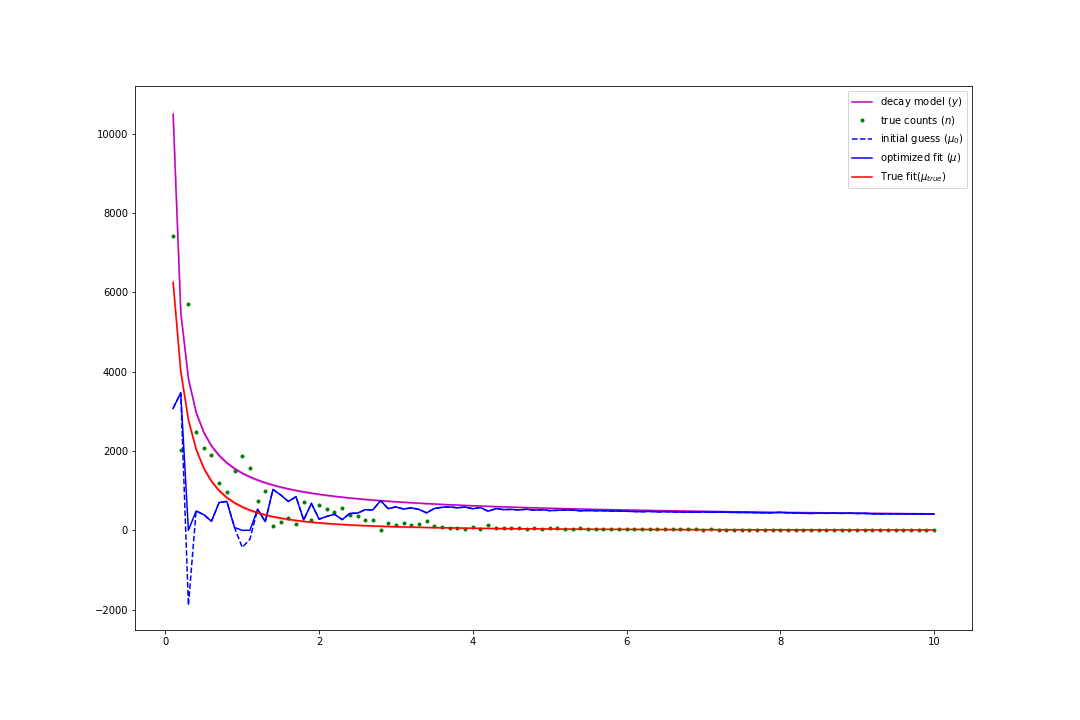

<IPython.core.display.Javascript object>


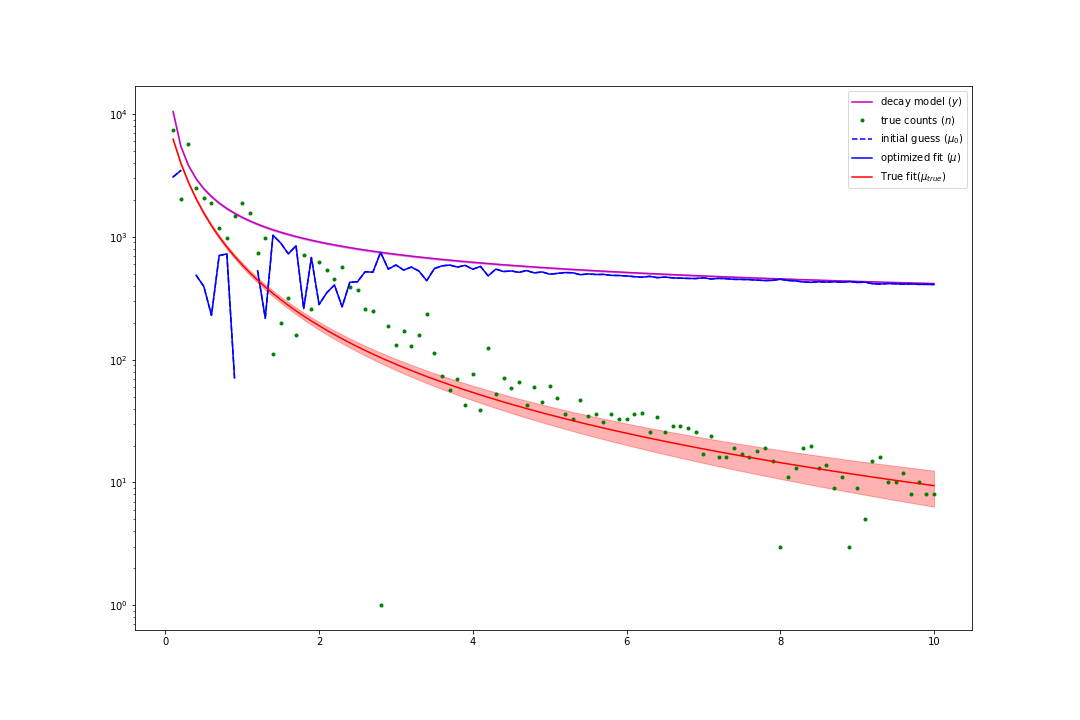

In [33]:
plt.figure(figsize=(15,10))

gp_std = np.sqrt(np.diag(cov))

plt.plot(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'm', alpha=0.3, edgecolor="none")
plt.plot(x, ytrueGP,'g.', label = "true counts ($n$)")
plt.plot(x, yguess-ytrueGP,'b--', label = "initial guess ($\mu_0$)")
plt.plot(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.legend(loc="upper right")
plt.figure(figsize=(15,10))

plt.semilogy(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'm', alpha=0.3, edgecolor="none")
plt.semilogy(x, ytrueGP,'g.', label = "true counts ($n$)")
plt.semilogy(x, yguess-ytrueGP,'b--', label = "initial guess ($\mu_0$)")
plt.semilogy(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.semilogy(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")

plt.legend(loc="upper right")
plt.show()

In [34]:
nln = neg_log_like_PGP_binned(yguess, np.zeros(len(n)), n, yguess, sigma)
nlng = nln_bin_gminerad(yguess, np.zeros(len(n)), n, yguess, sigma)

In [35]:
print np.diag(cov)

[6250.         4000.         2777.77777778 2040.81632653 1562.5
 1234.56790123 1000.          826.44628099  694.44444444  591.71597633
  510.20408163  444.44444444  390.625       346.02076125  308.64197531
  277.00831025  250.          226.75736961  206.61157025  189.03591682
  173.61111111  160.          147.92899408  137.17421125  127.55102041
  118.90606421  111.11111111  104.05827263   97.65625      91.82736455
   86.50519031   81.63265306   77.16049383   73.04601899   69.25207756
   65.74621959   62.5          59.48839976   56.6893424    54.08328826
   51.65289256   49.38271605   47.25897921   45.26935265   43.40277778
   41.64931279   40.           38.44675125   36.98224852   35.5998576
   34.29355281   33.05785124   31.8877551    30.77870114   29.72651605
   28.72737719   27.77777778   26.8744961    26.01456816   25.19526329
   24.4140625    23.66863905   22.95684114   22.27667632   21.62629758
   21.00399076   20.40816327   19.83733386   19.29012346   18.76524676
   18.26150475

In [36]:
from scipy.optimize import minimize
boundarray = [(0,None) for i in n]
signal0 = np.zeros(len(n))
soln = minimize(neg_log_like_PGP_binned, n,  bounds = boundarray, args = (signal0, n, yguess, sigma), jac=nln_bin_gminerad)
print soln

      fun: 2743522.640536095
 hess_inv: <100x100 LbfgsInvHessProduct with dtype=float64>
      jac: array([98.28489   , 98.58780766, 98.58864597, 98.52352735, 98.34266004,
       98.18296109, 97.97198137, 97.69712416, 97.54512541, 97.36558756,
       97.27138574, 97.02451003, 96.75713585, 96.52215089, 96.17381604,
       95.82291325, 95.52851339, 95.71963583, 94.24923662, 93.63280177,
       93.46347744, 93.44242703, 93.3598483 , 94.00535323, 92.56711755,
       93.10449285, 92.82933433, 92.44060774, 91.29124699, 91.22844368,
       88.93034983, 90.6428068 , 90.68350029, 88.62782384, 88.49825508,
       87.56409193, 88.63119615, 86.94827664, 88.59977099, 87.42002988,
       89.10758648, 79.74659555, 87.96967969, 82.92443945, 83.08809492,
       82.00417536, 83.39676727, 79.77537885, 84.71566345, 84.84149152,
       83.94932344, 82.46832066, 78.72051189, 78.17198053, 78.33724427,
       70.22664421, 74.22347227, 78.80298582, 85.5021089 , 75.77786495,
       79.22854355, 77.01519285, 71.

In [37]:
solnGP = minimize(neg_log_like_PGP_MV, ytrueGP,  bounds = boundarray, args = (signal0 , ytrueGP, yguess, cov), jac=nln_MV_grad)
print solnGP

      fun: 3570790.7109910944
 hess_inv: <100x100 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 98.93428108,  98.93716035,  98.98294827,  99.00082519,
        99.01642959,  99.02564211,  99.01310585,  99.00138217,
        99.01349003,  99.00903594,  98.99043029,  98.93694926,
        98.93859405,  98.11473388,  98.61154449,  98.75305489,
        98.45238239,  98.83195391,  98.65531425,  98.79488123,
        98.76860898,  98.7415206 ,  98.75876065,  98.71040579,
        98.69962066,  98.6250245 ,  98.61777048,  97.80510985,
        98.52749057,  98.27670724,  98.51215512,  98.30180864,
        98.50637293,  98.70213323,  98.21426498,  98.01136612,
        98.05909726,  98.10040684,  98.16691154,  98.2055886 ,
        98.30282334,  98.65670057,  98.4701577 ,  98.56094431,
        98.73041994,  98.90568078,  99.23410879,  99.52561803,
       100.09554104, 100.70576331, 101.87387766, 103.76340097,
       106.84717396, 112.39552197, 128.73986115, 259.45102716,
        24.111240

<IPython.core.display.Javascript object>


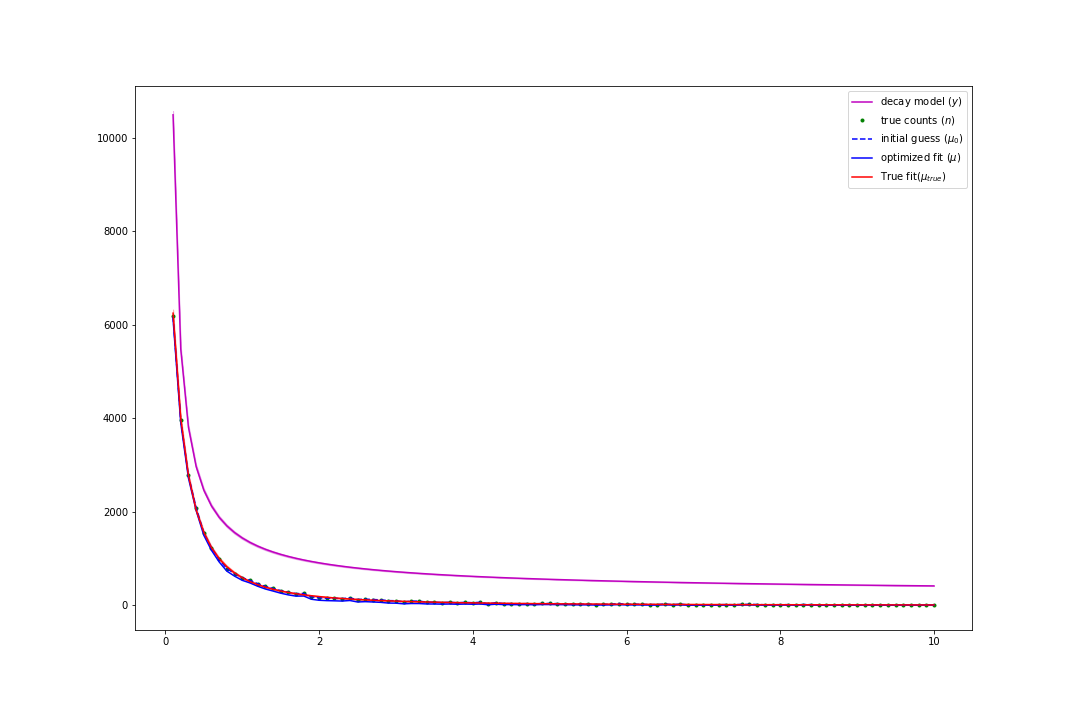

<IPython.core.display.Javascript object>


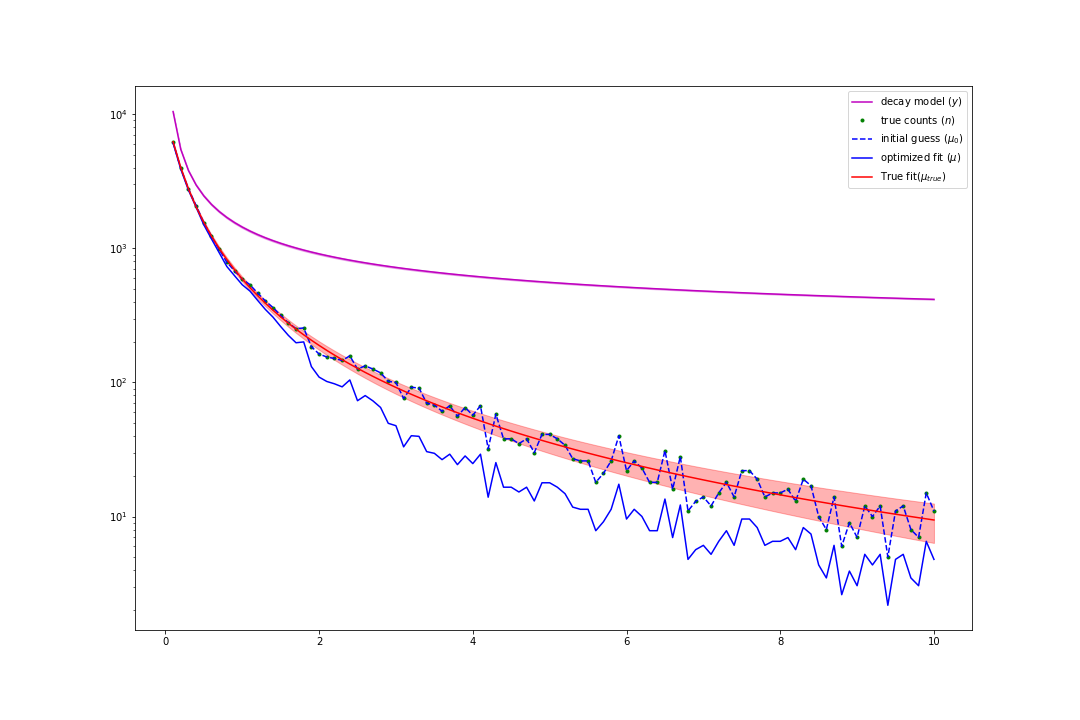

In [38]:
plt.figure(figsize=(15,10))

plt.plot(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+np.sqrt(np.diag(cov)), yguess-np.sqrt(np.diag(cov)), color = 'm', alpha=0.3, edgecolor="none")
plt.plot(x, n,'g.', label = "true counts ($n$)")
plt.plot(x, n,'b--', label = "initial guess ($\mu_0$)")
plt.plot(x, soln.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.legend(loc="upper right")
plt.figure(figsize=(15,10))

plt.semilogy(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+np.sqrt(np.diag(cov)), yguess-np.sqrt(np.diag(cov)), color = 'm', alpha=0.3, edgecolor="none")
plt.semilogy(x, n,'g.', label = "true counts ($n$)")
plt.semilogy(x, n,'b--', label = "initial guess ($\mu_0$)")
plt.semilogy(x, soln.x,'b-', label = "optimized fit ($\mu$)")
plt.semilogy(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")

plt.legend(loc="upper right")
plt.show()

<IPython.core.display.Javascript object>


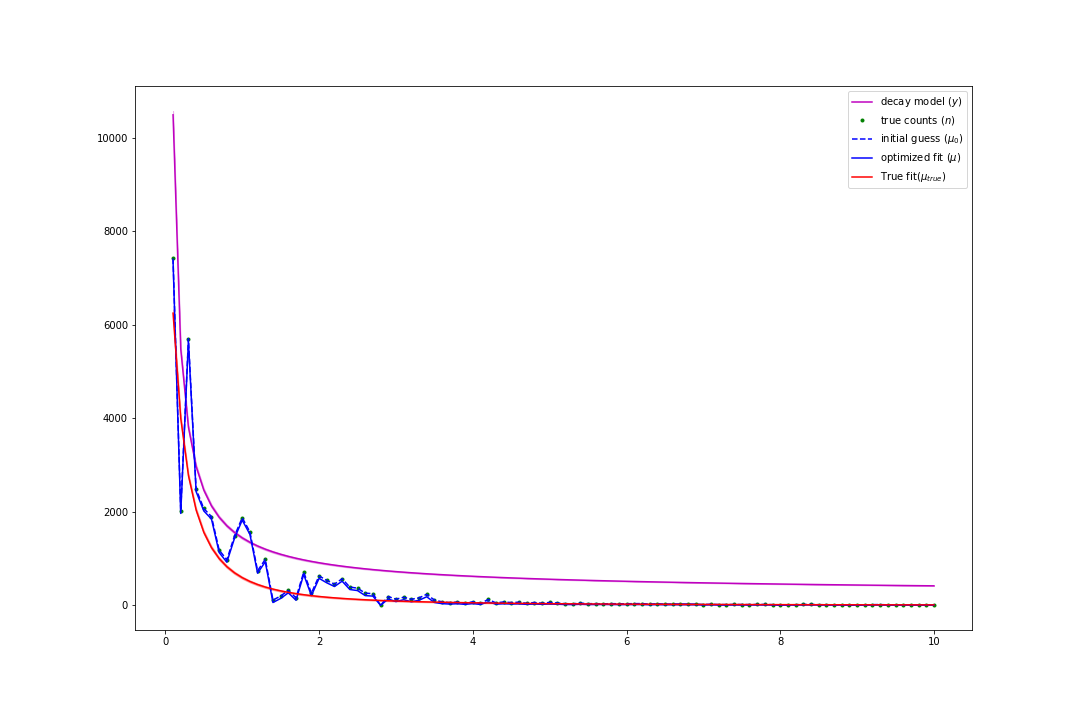

<IPython.core.display.Javascript object>


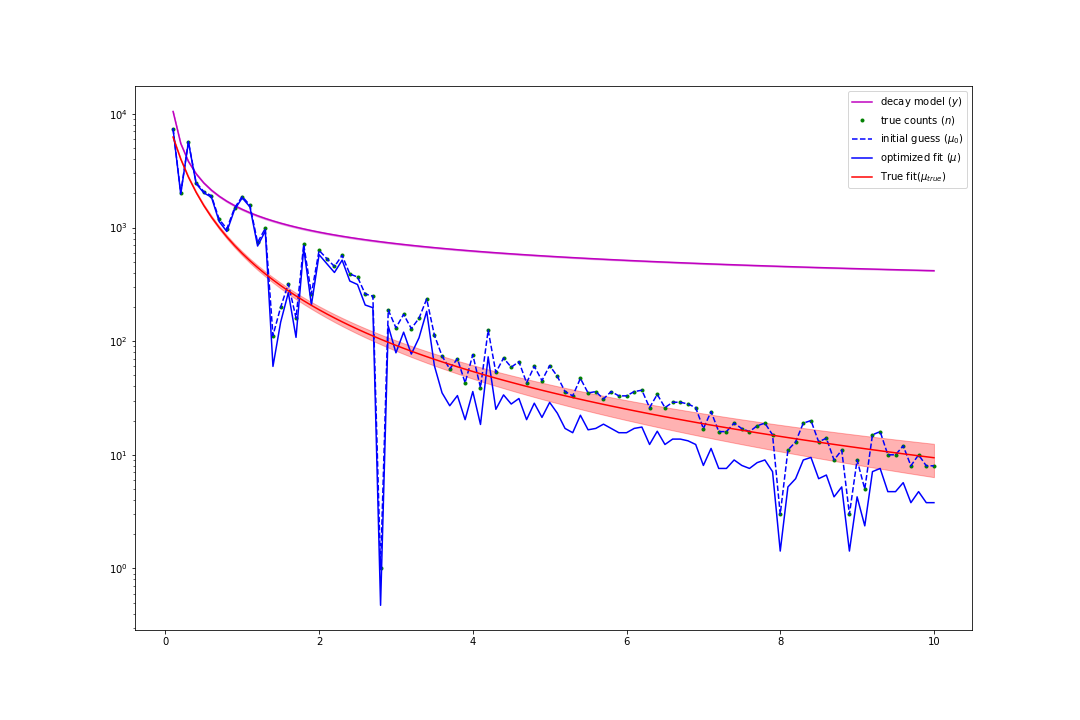

In [39]:
plt.figure(figsize=(15,10))

gp_std = np.sqrt(np.diag(cov))

plt.plot(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'm', alpha=0.3, edgecolor="none")
plt.plot(x, ytrueGP,'g.', label = "true counts ($n$)")
plt.plot(x, ytrueGP,'b--', label = "initial guess ($\mu_0$)")
plt.plot(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.legend(loc="upper right")
plt.figure(figsize=(15,10))

plt.semilogy(x, yguess, 'm-', label = "decay model ($y$)")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'm', alpha=0.3, edgecolor="none")
plt.semilogy(x, ytrueGP,'g.', label = "true counts ($n$)")
plt.semilogy(x, ytrueGP,'b--', label = "initial guess ($\mu_0$)")
plt.semilogy(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.semilogy(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")

plt.legend(loc="upper right")
plt.show()

2963531.701082399


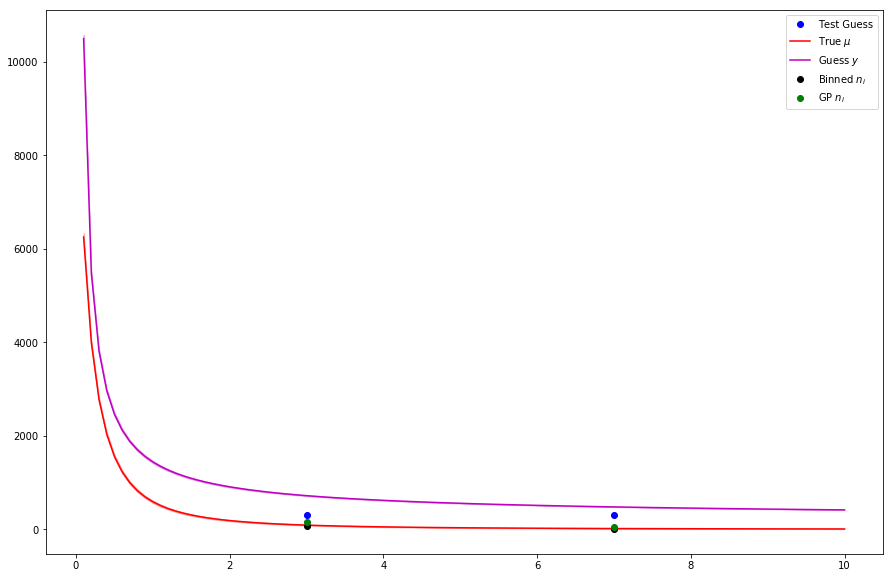

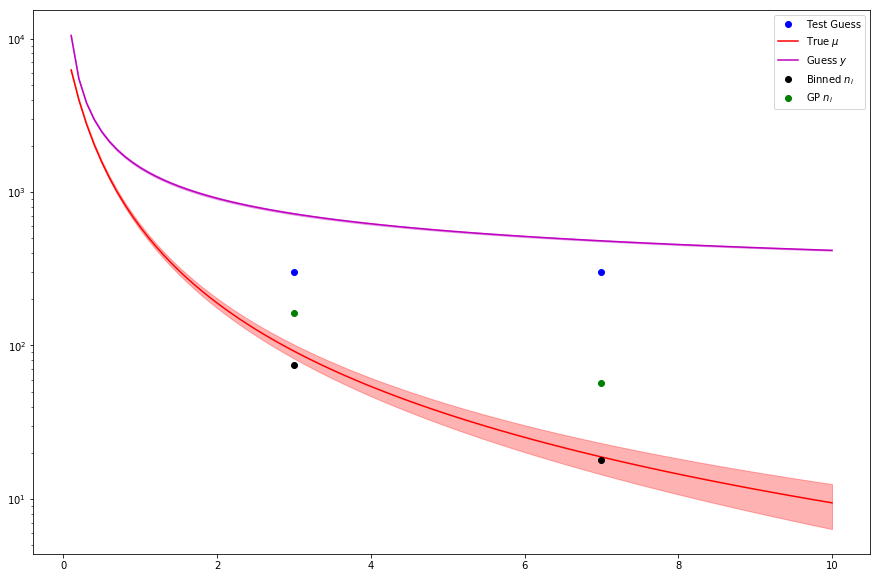

In [84]:
xtest = np.array([3., 7.])
y_g = f4(xtest)
y_t = f5(xtest)
n_bin = poisson(y_t)
cov_test = makekernel(xtest, kernel1, kparams, y_t)
print linalg.det(cov_test)
n_gp = simulate(y_t, cov_test)
n_guess = np.array([300.,300.])
%matplotlib inline

plt.figure(figsize=(15,10))
plt.plot(xtest, n_guess, 'bo', label = "Test Guess")
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, yguess, 'm-', label = "Guess $y$")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'm', alpha=0.3, edgecolor="none")

plt.plot(xtest, n_bin, 'ko', label = "Binned $n_i$")
plt.plot(xtest, n_gp, 'go', label = "GP $n_i$")

plt.legend(loc="upper right")

plt.figure(figsize=(15,10))
plt.semilogy(xtest, n_guess, 'bo', label = "Test Guess")
plt.semilogy(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.semilogy(x, yguess, 'm-', label = "Guess $y$")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'm', alpha=0.3, edgecolor="none")

plt.semilogy(xtest, n_bin, 'ko', label = "Binned $n_i$")
plt.semilogy(xtest, n_gp, 'go', label = "GP $n_i$")

plt.legend(loc="upper right")

plt.show()

In [119]:
stest = np.array([0.,0.])
ll_0 = -neg_log_like_PGP_MV(n_guess, stest, n_gp, y_g, cov_test)
llg_0 = -nln_MV_grad(n_guess, stest, n_gp, y_g, cov_test)
bound_test = [(0,None) for i in range(2)]

x3d = []
y3d = []
z3d = []
z3d_gradx = []
z3d_grady = []


#for mu1 in np.logspace(0.,np.log10(500), 30):
#    for mu2 in np.logspace(0.,np.log10(500), 30):
        
for mu1 in np.linspace(200,400, 30):
    for mu2 in np.linspace(200,400, 30):
        x3d.append(mu1)
        y3d.append(mu2)
        mutest = np.array([mu1,mu2])
        ll = -neg_log_like_PGP_MV(mutest, stest, n_gp, y_g, cov_test)
        ll_grad = -nln_MV_grad(mutest, stest, n_gp, y_g, cov_test)
        z3d.append(ll)
        z3d_gradx.append(ll_grad[0])
        z3d_grady.append(ll_grad[1])
   
soln_test = minimize(neg_log_like_PGP_MV, n_guess,  bounds = bound_test, args = (stest, n_gp, y_g, cov_test), jac=nln_MV_grad, options={'ftol': 1e-20, 'gtol':1e-20, 'eps':1e-20})
print soln_test


      fun: 19.06083422966185
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.41187403, 1.30156142])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 5
      nit: 2
   status: 0
  success: True
        x: array([298.58543305, 298.69392779])


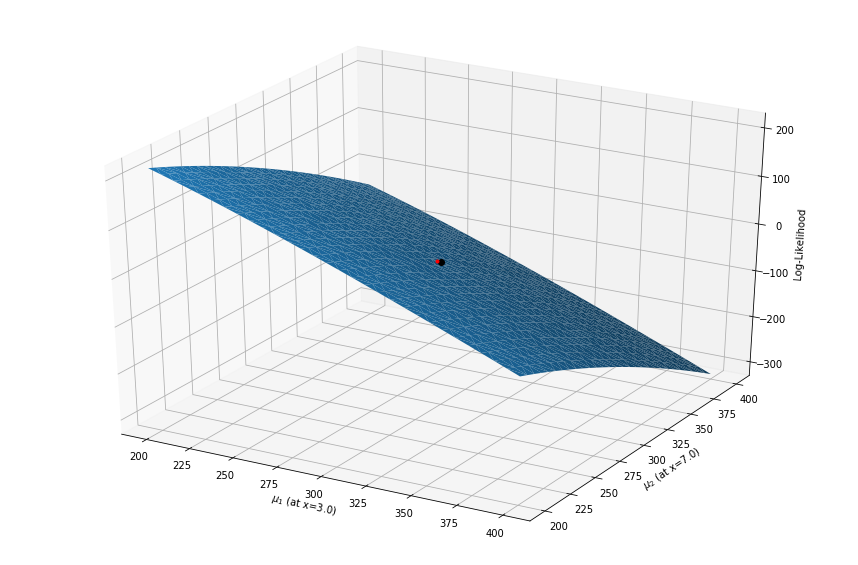

In [113]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

ax.set_xlabel('$\mu_1$ (at x=' + str(xtest[0])+')')
ax.set_ylabel('$\mu_2$ (at x=' + str(xtest[1])+')')
ax.set_zlabel('Log-Likelihood')

ax.plot_trisurf(x3d,y3d,z3d)
ax.plot([n_guess[0]],[n_guess[1]], [ll_0], 'ko')
ax.plot([soln_test.x[0]],[soln_test.x[1]], [-soln_test.fun], 'r.')
plt.show()

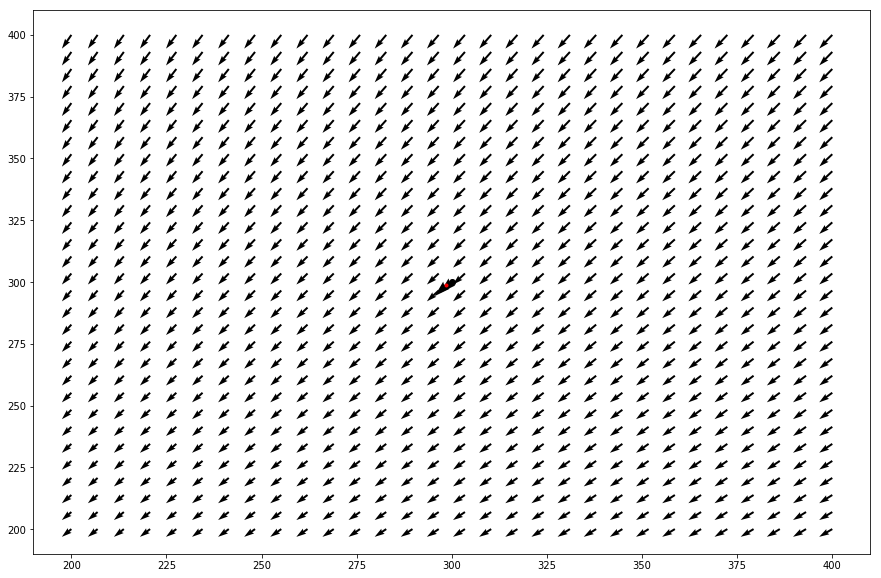

In [114]:
plt.figure(figsize=(15,10))



plt.quiver(x3d,y3d,z3d_gradx, z3d_grady, scale=1e2)
plt.quiver([n_guess[0]], [n_guess[1]], llg_0[0], llg_0[1], scale=1e2)
plt.quiver([soln_test.x[0]],[soln_test.x[1]], -soln_test.jac[0], -soln_test.jac[1], scale=1e2)
plt.plot([n_guess[0]],[n_guess[1]], 'ko')
plt.plot([soln_test.x[0]],[soln_test.x[1]],  'r.')
plt.show()

In [115]:
print z3d_grad[:][0]

[-298.07330405 -299.34702846]
